In [1]:
import sqlalchemy as db
import pandas as pd

In [2]:
engine = db.create_engine("sqlite:///mta_data.db")

In [3]:
df = pd.read_sql("SELECT * FROM mta_data;", engine)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17191756 entries, 0 to 17191755
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 1.4+ GB


In [5]:
def get_daily_counts(row, max_counter, turnstile_direction):
    count_name = turnstile_direction
    prev_count_name = f"PREV_{turnstile_direction}"
    counter = row[count_name] - row[prev_count_name]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0?
        print(row[count_name], row[prev_count_name])
        counter = min(row[count_name], row[prev_count_name])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

In [6]:
import calendar

def stations_monthly(data, stations, month, year, turnstile_direction):
    data = data[data.STATION.isin(stations)]
    data.loc[:, "DATE_FORMATTED"] = pd.to_datetime(data.loc[:, "DATE"])
    data = data[(data.DATE_FORMATTED.dt.month == month) & (data.DATE_FORMATTED.dt.year == year)]
    turnstiles_daily = (data.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_FORMATTED"],as_index=False)[turnstile_direction].max())
    turnstiles_daily[["PREV_DATE", f"PREV_{turnstile_direction}"]] = turnstiles_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE_FORMATTED", turnstile_direction]].shift(1)
    turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
    turnstiles_daily[f"DAILY_{turnstile_direction}"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=500000, turnstile_direction=turnstile_direction)
    print(turnstiles_daily[f"DAILY_{turnstile_direction}"].describe().apply(lambda x: '%.0f' % x))
    print(turnstiles_daily.groupby("STATION").size())
    station_totals = turnstiles_daily.groupby("STATION")[f"DAILY_{turnstile_direction}"].sum()
    return station_totals.rename(f"{calendar.month_abbr[month].upper()}_{turnstile_direction}")

In [7]:
crazy_stations = ['GRD CNTRL-42 ST', 'WALL ST', 'HOWARD BCH JFK', '161/YANKEE STAD', 'CONEY IS-STILLW', 'BLEECKER ST', '116 ST-COLUMBIA', 'FORDHAM RD', 'BRONX PARK EAST', 'BEACH 67 ST', 'SOUTH FERRY', '5 AVE', 'JAMAICA VAN WK', 'BROOKLYN BRIDGE', 'LAFAYETTE AV']

In [9]:
def station_percent_change(month, turnstile_direction, data=df, stations=crazy_stations, newer_year=2021, older_year=2019):
    newer_month_count = stations_monthly(data, stations, month, newer_year, turnstile_direction)
    older_month_count = stations_monthly(data, stations, month, older_year, turnstile_direction)

    count_change = (newer_month_count - older_month_count) / older_month_count * 100
    return count_change.round(1)

In [21]:
ss = []

for month_num in range(1,10):
    ss.append(station_percent_change(month_num, "ENTRIES"))
    ss.append(station_percent_change(month_num, "EXITS"))

changes_19_21 = pd.concat(ss, axis=1)
changes_19_21 = changes_19_21.sort_values(by="JAN_ENTRIES", ascending=False)
changes_19_21

66 500623.0
779 2844722.0
count     9417
mean       197
std        983
min          0
25%          1
50%         88
75%        245
max      65527
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1110
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GRD CNTRL-42 ST    2661
HOWARD BCH JFK      430
JAMAICA VAN WK      210
LAFAYETTE AV        300
SOUTH FERRY         630
WALL ST            1500
dtype: int64
1629 2353351.0
11 270306326.0
16 1847577.0
787 3173773.0
589826 201857085.0
count      8664
mean       1028
std        4432
min           0
25%          79
50%         628
75%        1467
max      294807
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1050
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRIDGE     509
CONEY IS-STILLW     600

161 1075170.0
2120 1508657739.0
count      9144
mean        256
std        2097
min           0
25%          16
50%         111
75%         300
max      197844
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     174
161/YANKEE STAD    1073
5 AVE               290
BEACH 67 ST         145
BLEECKER ST         261
BRONX PARK EAST      87
BROOKLYN BRIDGE     493
CONEY IS-STILLW     580
FORDHAM RD          460
GRD CNTRL-42 ST    2565
HOWARD BCH JFK      464
JAMAICA VAN WK      203
LAFAYETTE AV        290
SOUTH FERRY         609
WALL ST            1450
dtype: int64
2020 5739414.0
17 900047.0
4702 3537698.0
3869 13835021.0
1510932084 6539833.0
count      8461
mean        894
std        2794
min           0
25%         114
50%         446
75%        1106
max      194492
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     173
161/YANKEE STAD    1073
5 AVE               290
BEACH 67 ST         145
BLEECKER ST         261
BRONX PARK EAST      87
BROOKLYN BRIDGE     492
CONEY IS-S

1962917910 9137598.0
117 545570.0
2503 1285262.0
3173 10213754.0
count      8747
mean       1245
std        9759
min           0
25%         156
50%         766
75%        1490
max      458909
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1102
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRIDGE     508
CONEY IS-STILLW     600
FORDHAM RD          479
GRD CNTRL-42 ST    1962
HOWARD BCH JFK      466
JAMAICA VAN WK      210
LAFAYETTE AV        300
SOUTH FERRY         630
WALL ST            1500
dtype: int64
604001837 2369108.0
count    9470
mean      331
std       468
min         0
25%        36
50%       175
75%       428
max      4055
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1110
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     600
FORDHAM RD          480
GR

,JAN_ENTRIES,JAN_EXITS,FEB_ENTRIES,FEB_EXITS,MAR_ENTRIES,MAR_EXITS,APR_ENTRIES,APR_EXITS,MAY_ENTRIES,MAY_EXITS,JUN_ENTRIES,JUN_EXITS,JUL_ENTRIES,JUL_EXITS,AUG_ENTRIES,AUG_EXITS,SEP_ENTRIES,SEP_EXITS
STATION,,,,,,,,,,,,,,,,,,
FORDHAM RD,-46.2,32.5,-64.8,-69.7,-53.8,-36.1,-53.8,-35.7,-74.7,-37.4,-40.9,-33.3,-53.8,-34.0,-52.7,-32.7,-55.7,-39.5
CONEY IS-STILLW,-53.5,-48.7,-55.3,-51.2,-50.2,-45.5,-55.5,9.9,-56.8,-45.7,-43.9,-42.5,-56.1,-37.9,-78.5,-44.0,-50.9,-38.2
BEACH 67 ST,-54.6,-47.3,-60.6,-52.1,-60.7,-49.8,-57.0,-45.3,-48.3,-31.3,-53.8,-35.4,-57.9,-44.1,-58.9,-43.2,-44.6,-21.3
JAMAICA VAN WK,-57.1,-59.0,-61.8,-59.7,-58.2,-53.3,-58.2,-52.0,-61.9,-57.3,-47.2,-35.0,-42.1,-21.1,-48.4,-30.5,-52.8,-36.7
BRONX PARK EAST,-62.0,-43.8,-62.6,-43.0,-58.9,-38.2,-57.6,-35.9,-54.5,-34.1,-52.8,-32.1,-52.1,-24.9,-52.0,-23.6,-49.7,-23.1
161/YANKEE STAD,-62.1,-52.6,-59.6,-48.2,-60.3,-49.0,-65.3,-56.5,-65.5,-56.2,-61.3,-45.6,-58.3,-43.7,-65.6,-52.8,-55.4,-36.4
HOWARD BCH JFK,-66.2,-90.3,-73.4,-95.5,-84.3,-96.7,-79.5,-95.3,-51.0,-87.1,-63.3,27.7,-51.3,-66.4,-51.6,-66.8,-51.7,-78.9
LAFAYETTE AV,-73.2,-56.6,-71.9,-59.4,-70.5,-52.8,-67.7,-48.4,-67.9,-45.0,-69.5,-48.8,-64.3,-37.2,-61.6,-31.0,-59.4,-32.7
BLEECKER ST,-80.4,-70.6,-86.1,-91.9,-64.2,-64.0,-76.8,-67.2,-72.6,-59.4,-68.4,-55.4,-67.1,-50.3,-77.1,-54.1,-69.2,-46.3


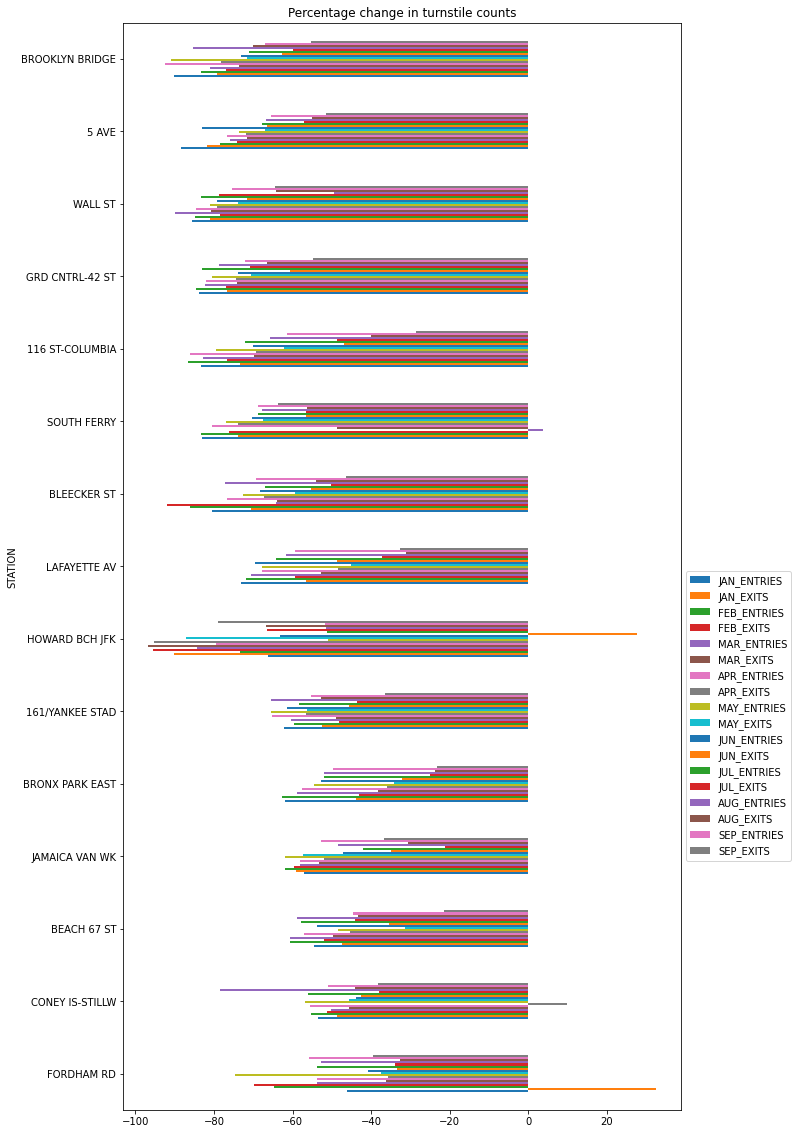

In [22]:
changes_19_21.plot.barh(title="Percentage change in turnstile counts", figsize=(10,20)).legend(bbox_to_anchor=(1,0.5))

In [24]:
entries_19_21 = changes_19_21[changes_19_21.columns[::2]]
entries_19_21

,JAN_ENTRIES,FEB_ENTRIES,MAR_ENTRIES,APR_ENTRIES,MAY_ENTRIES,JUN_ENTRIES,JUL_ENTRIES,AUG_ENTRIES,SEP_ENTRIES
STATION,,,,,,,,,
FORDHAM RD,-46.2,-64.8,-53.8,-53.8,-74.7,-40.9,-53.8,-52.7,-55.7
CONEY IS-STILLW,-53.5,-55.3,-50.2,-55.5,-56.8,-43.9,-56.1,-78.5,-50.9
BEACH 67 ST,-54.6,-60.6,-60.7,-57.0,-48.3,-53.8,-57.9,-58.9,-44.6
JAMAICA VAN WK,-57.1,-61.8,-58.2,-58.2,-61.9,-47.2,-42.1,-48.4,-52.8
BRONX PARK EAST,-62.0,-62.6,-58.9,-57.6,-54.5,-52.8,-52.1,-52.0,-49.7
161/YANKEE STAD,-62.1,-59.6,-60.3,-65.3,-65.5,-61.3,-58.3,-65.6,-55.4
HOWARD BCH JFK,-66.2,-73.4,-84.3,-79.5,-51.0,-63.3,-51.3,-51.6,-51.7
LAFAYETTE AV,-73.2,-71.9,-70.5,-67.7,-67.9,-69.5,-64.3,-61.6,-59.4
BLEECKER ST,-80.4,-86.1,-64.2,-76.8,-72.6,-68.4,-67.1,-77.1,-69.2


In [25]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

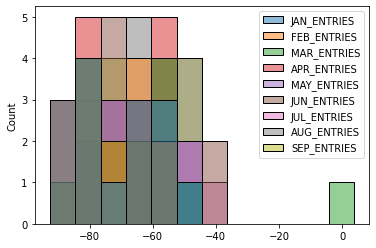

In [38]:
sns.histplot(data = entries_19_21)

In [33]:
entries_19_21.columns

Index(['JAN_ENTRIES', 'FEB_ENTRIES', 'MAR_ENTRIES', 'APR_ENTRIES',
       'MAY_ENTRIES', 'JUN_ENTRIES', 'JUL_ENTRIES', 'AUG_ENTRIES',
       'SEP_ENTRIES'],
      dtype='object')

In [34]:
entries_19_21.index

Index(['FORDHAM RD', 'CONEY IS-STILLW', 'BEACH 67 ST', 'JAMAICA VAN WK',
       'BRONX PARK EAST', '161/YANKEE STAD', 'HOWARD BCH JFK', 'LAFAYETTE AV',
       'BLEECKER ST', 'SOUTH FERRY', '116 ST-COLUMBIA', 'GRD CNTRL-42 ST',
       'WALL ST', '5 AVE', 'BROOKLYN BRIDGE'],
      dtype='object', name='STATION')

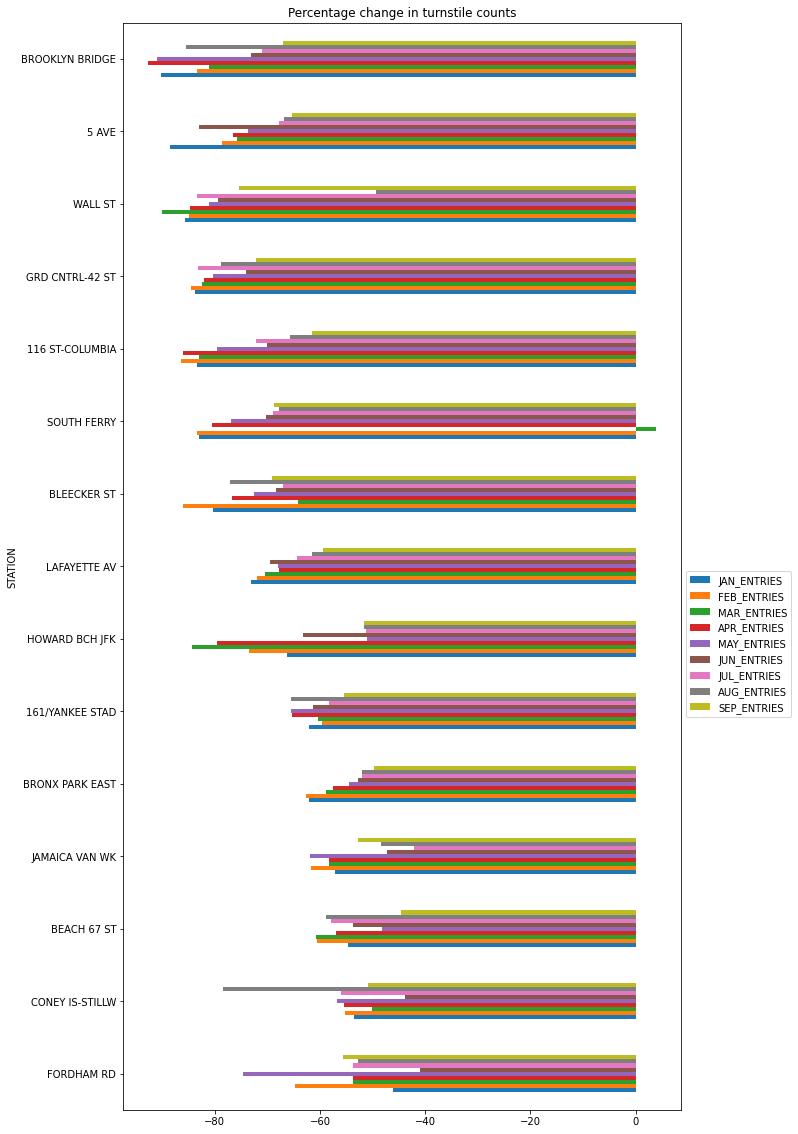

In [39]:
entries_19_21.plot.barh(title="Percentage change in turnstile counts", figsize=(10,20)).legend(bbox_to_anchor=(1,0.5))

In [54]:
entries_transposed = entries_19_21.transpose()
entries_transposed = entries_transposed.apply(lambda x: -x)
entries_transposed = entries_transposed[entries_transposed.columns[::-1]]
entries_transposed

STATION,BROOKLYN BRIDGE,5 AVE,WALL ST,GRD CNTRL-42 ST,116 ST-COLUMBIA,SOUTH FERRY,BLEECKER ST,LAFAYETTE AV,HOWARD BCH JFK,161/YANKEE STAD,BRONX PARK EAST,JAMAICA VAN WK,BEACH 67 ST,CONEY IS-STILLW,FORDHAM RD
JAN_ENTRIES,90.3,88.5,85.7,83.7,83.4,83.0,80.4,73.2,66.2,62.1,62.0,57.1,54.6,53.5,46.2
FEB_ENTRIES,83.4,78.6,84.9,84.5,86.5,83.3,86.1,71.9,73.4,59.6,62.6,61.8,60.6,55.3,64.8
MAR_ENTRIES,81.1,75.8,90.0,82.4,82.9,-3.8,64.2,70.5,84.3,60.3,58.9,58.2,60.7,50.2,53.8
APR_ENTRIES,92.6,76.6,84.7,82.1,86.0,80.5,76.8,67.7,79.5,65.3,57.6,58.2,57.0,55.5,53.8
MAY_ENTRIES,91.0,73.7,81.0,80.4,79.6,76.9,72.6,67.9,51.0,65.5,54.5,61.9,48.3,56.8,74.7
JUN_ENTRIES,73.1,83.0,79.3,74.0,70.1,70.2,68.4,69.5,63.3,61.3,52.8,47.2,53.8,43.9,40.9
JUL_ENTRIES,71.0,67.7,83.4,83.1,72.1,68.9,67.1,64.3,51.3,58.3,52.1,42.1,57.9,56.1,53.8
AUG_ENTRIES,85.4,66.8,49.4,78.8,65.7,67.7,77.1,61.6,51.6,65.6,52.0,48.4,58.9,78.5,52.7
SEP_ENTRIES,67.0,65.4,75.3,72.1,61.5,68.7,69.2,59.4,51.7,55.4,49.7,52.8,44.6,50.9,55.7


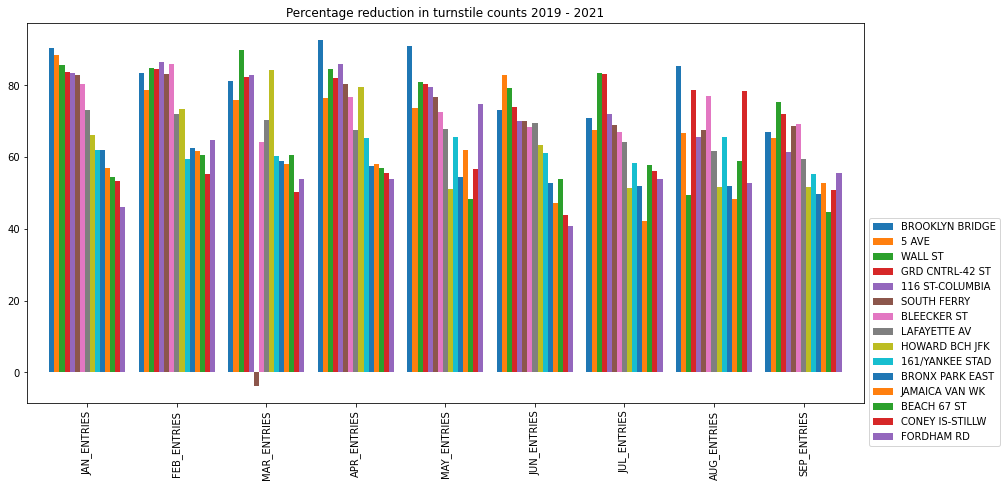

In [82]:
entries_transposed.plot.bar(title="Percentage reduction in turnstile counts 2019 - 2021", figsize=(15,7), width=0.85).legend(bbox_to_anchor=(1,0.5))

In [65]:
june_total_entries = stations_monthly(df, crazy_stations, 6, 2021, "ENTRIES")
june_total_entries.sort_values(inplace=True)

687970551 19471253.0
count     9118
mean       328
std       1359
min          0
25%         38
50%        206
75%        414
max      72806
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     174
161/YANKEE STAD    1072
5 AVE               290
BEACH 67 ST         145
BLEECKER ST         261
BRONX PARK EAST      87
BROOKLYN BRIDGE     493
CONEY IS-STILLW     579
FORDHAM RD          464
GRD CNTRL-42 ST    2568
HOWARD BCH JFK      464
JAMAICA VAN WK      203
LAFAYETTE AV        290
SOUTH FERRY         609
WALL ST            1419
dtype: int64


In [66]:
june_total_entries

STATION
BRONX PARK EAST     29958.0
BEACH 67 ST         30456.0
LAFAYETTE AV        39190.0
JAMAICA VAN WK      53492.0
116 ST-COLUMBIA     77404.0
5 AVE              102073.0
SOUTH FERRY        127636.0
BROOKLYN BRIDGE    127939.0
HOWARD BCH JFK     130589.0
BLEECKER ST        133404.0
WALL ST            240364.0
CONEY IS-STILLW    296586.0
161/YANKEE STAD    302649.0
FORDHAM RD         327131.0
GRD CNTRL-42 ST    968481.0
Name: JUN_ENTRIES, dtype: float64

In [67]:
june_total_entries.sum()

2987352.0

In [72]:
# month_total_newer = stations_monthly(df, crazy_stations, 6, 2021, "ENTRIES").sum() + stations_monthly(df, crazy_stations, 6, 2021, "EXITS").sum()
# month_total_older = stations_monthly(df, crazy_stations, 6, 2019, "ENTRIES").sum() + stations_monthly(df, crazy_stations, 6, 2019, "EXITS").sum()
# month_total_older 

def total_percent_change(month, data=df, stations=crazy_stations, newer_year=2021, older_year=2019):
    month_total_newer = stations_monthly(data, stations, month, newer_year, "ENTRIES").sum() + stations_monthly(data, stations, month, newer_year, "EXITS").sum()
    month_total_older = stations_monthly(data, stations, month, older_year, "ENTRIES").sum() + stations_monthly(data, stations, month, older_year, "EXITS").sum()

    percent_change = (month_total_newer - month_total_older) / month_total_older * 100
    return percent_change.round(1)




In [70]:
r = [1, 2, 3]
n = pd.Series(r, index=['jan', 'feb', 'march'])
n

jan      1
feb      2
march    3
dtype: int64

In [74]:
values = []
months = []

for month_num in range(1,10):
    values.append(total_percent_change(month_num))
    months.append(calendar.month_abbr[month_num].upper())

totals_19_21 = pd.Series(values, index=months)
totals_19_21

66 500623.0
779 2844722.0
count     9417
mean       197
std        983
min          0
25%          1
50%         88
75%        245
max      65527
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1110
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GRD CNTRL-42 ST    2661
HOWARD BCH JFK      430
JAMAICA VAN WK      210
LAFAYETTE AV        300
SOUTH FERRY         630
WALL ST            1500
dtype: int64
59 805938.0
435 2837182.0
count      9417
mean        203
std        1564
min           0
25%           3
50%          70
75%         226
max      130556
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1110
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     596
FORDHAM RD          480
GRD CNTRL-42 ST    2661
HOW

2020 5739414.0
17 900047.0
4702 3537698.0
3869 13835021.0
1510932084 6539833.0
count      8461
mean        894
std        2794
min           0
25%         114
50%         446
75%        1106
max      194492
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     173
161/YANKEE STAD    1073
5 AVE               290
BEACH 67 ST         145
BLEECKER ST         261
BRONX PARK EAST      87
BROOKLYN BRIDGE     492
CONEY IS-STILLW     580
FORDHAM RD          464
GRD CNTRL-42 ST    1880
HOWARD BCH JFK      464
JAMAICA VAN WK      203
LAFAYETTE AV        290
SOUTH FERRY         609
WALL ST            1450
dtype: int64
101 2651127.0
count    9466
mean      252
std       323
min         0
25%        23
50%       155
75%       347
max      2632
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1110
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRIDGE     510
CONEY IS-STILLW     600
FORDHAM RD        

1962917910 9137598.0
117 545570.0
2503 1285262.0
3173 10213754.0
count      8747
mean       1245
std        9759
min           0
25%         156
50%         766
75%        1490
max      458909
Name: DAILY_ENTRIES, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1102
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRIDGE     508
CONEY IS-STILLW     600
FORDHAM RD          479
GRD CNTRL-42 ST    1962
HOWARD BCH JFK      466
JAMAICA VAN WK      210
LAFAYETTE AV        300
SOUTH FERRY         630
WALL ST            1500
dtype: int64
318790192 1305662.0
5514 555556.0
2279 878220.0
12769 13304779.0
count      8747
mean        911
std        5073
min           0
25%         106
50%         427
75%        1012
max      327243
Name: DAILY_EXITS, dtype: object
STATION
116 ST-COLUMBIA     180
161/YANKEE STAD    1102
5 AVE               300
BEACH 67 ST         150
BLEECKER ST         270
BRONX PARK EAST      90
BROOKLYN BRID

JAN   -75.7
FEB   -77.4
MAR   -72.8
APR   -74.8
MAY   -72.9
JUN   -63.7
JUL   -70.6
AUG   -67.2
SEP   -60.6
dtype: float64

In [78]:
totals_19_21 = totals_19_21.apply(lambda x: -x)

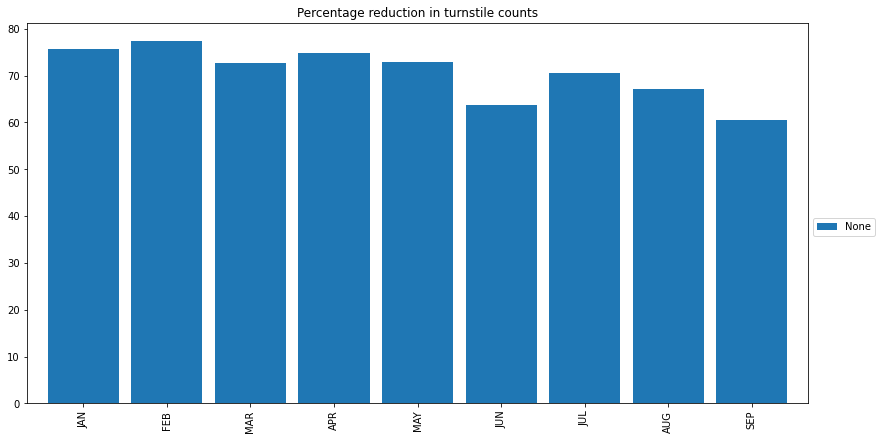

In [81]:
totals_19_21.plot.bar(title="Percentage reduction in turnstile counts", figsize=(14,7), width=0.85).legend(bbox_to_anchor=(1,0.5))

In [90]:
%store -r monthly_cases
monthly_cases

JAN    137485
FEB     86462
MAR     92016
APR     54334
MAY     13564
JUN      5248
JUL     18689
AUG     45989
SEP     38507
dtype: int64

In [86]:
type(totals_19_21)

pandas.core.series.Series

In [87]:
type(monthly_covid_cases)

pandas.core.series.Series

In [116]:
turnstiles_covid = pd.concat([totals_19_21, monthly_cases], axis=1)

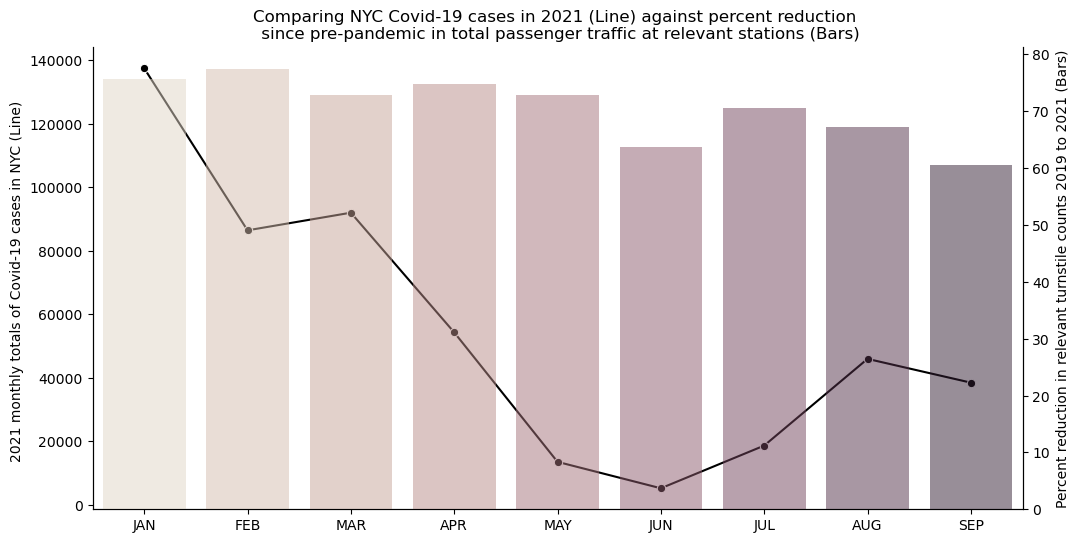

In [171]:
import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rc_file_defaults()
# ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = turnstiles_covid[1], marker='o', color='black', ax=ax1)
ax2 = ax1.twinx()

sns.barplot(x=turnstiles_covid.index, y=0, palette="ch:.25", data=turnstiles_covid, alpha=0.5, ax=ax2)
ax1.set_title('Comparing NYC Covid-19 cases in 2021 (Line) against percent reduction \n since pre-pandemic in total passenger traffic at relevant stations (Bars)')
ax1.set_ylabel('2021 monthly totals of Covid-19 cases in NYC (Line) ')
ax2.set_ylabel('Percent reduction in relevant turnstile counts 2019 to 2021 (Bars)')
sns.despine(right=False)

plt.savefig('turnstiles_versus_cases.png', dpi=300)



